This notebook dig a little deeper than previous version. Differences are:

1) I try to understand the synthetic data more; <br>
2) I format the print out values better (define decimals); <br>
3) Find out how's the err (+/-) get calculated from solution for linear leaset square; <br>
4) understand better about results from scipy.optimize.minimize function;

In [1]:
# dependencies
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import corner

In [2]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

In [3]:
# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true

In [4]:
# check the y values now
y

array([ 4.1388684 ,  3.77467716,  3.41382508,  3.40966335,  2.99319198,
        2.7997341 ,  2.51908366,  2.31420396,  1.94631017,  1.63120235,
        1.60285128,  1.40712941,  1.24756597,  1.1622203 ,  1.14372306,
        0.74183178,  0.73134005,  0.71559076,  0.57460095,  0.47694541,
        0.47427439,  0.16309392,  0.10054046, -0.12480134, -0.22531534,
       -0.28457232, -0.37987222, -0.48766586, -0.59887649, -0.81610827,
       -0.94685941, -0.95226499, -0.96635782, -1.11289416, -1.50402104,
       -1.67354512, -1.90108981, -2.12448039, -2.15836255, -2.1687584 ,
       -2.2727288 , -2.58026865, -2.88061385, -3.08296639, -3.41739759,
       -3.56030741, -3.84514167, -4.31777923, -4.41773327, -5.05468234])

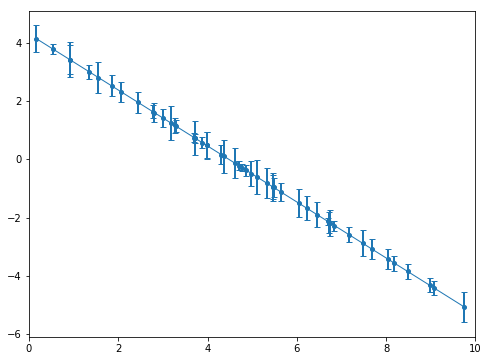

In [5]:
# plot the synthetic data
fig = plt.figure(figsize=(8,6))
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4, linewidth=1, linestyle='solid')
plt.xlim(0, 10)
plt.show()

In [6]:
# generate variation for y
y += np.abs(f_true*y) * np.random.randn(N)

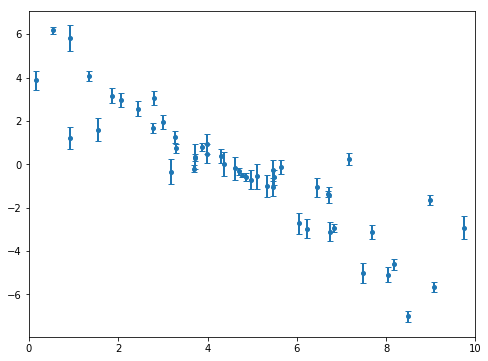

In [7]:
# plot the synthetic data
fig = plt.figure(figsize=(8,6))
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.show()

In [8]:
# generate more variation for y
y += yerr * np.random.randn(N)

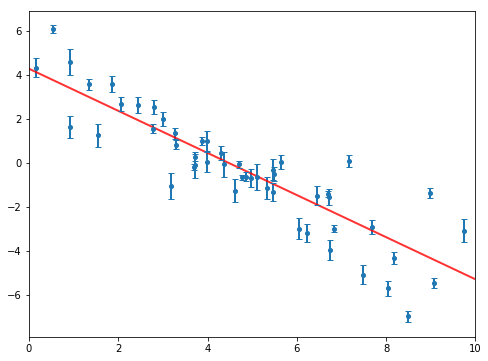

In [9]:
# plot the synthetic data along with perfect model
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.show()

In [10]:
# linear least squares solution to these data
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print(f"the results are: m={m_ls:.02f} and b={b_ls:.02f}")

the results are: m=-1.07 and b=4.86


In [11]:
cov

array([[ 0.00797824, -0.00137293],
       [-0.00137293,  0.00028474]])

In [12]:
err_xy = np.sqrt(np.diag(cov))

In [13]:
err_xy

array([0.08932102, 0.01687412])

In [17]:
print(f"the results are: m= {m_ls:.02f} +/- {err_xy[1]:.04f} and b= {b_ls:.02f} +/- {err_xy[0]:.04f}")

the results are: m= -1.07 +/- 0.0169 and b= 4.86 +/- 0.0893


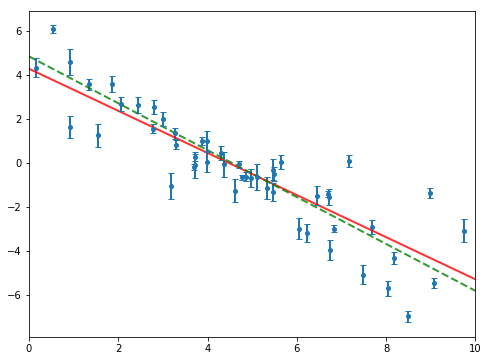

In [18]:
# plotted as a dashed green line
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="g", linestyle='dashed', lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.show()

In [19]:
# likelihood function is simply a Gaussian where the variance is underestimated by some fractional amount: f. 
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [24]:
# finding this numerical optimum of this likelihood function using the scipy.optimize module
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print(f"current results are m={m_ml:.03f}, b={b_ml:.03f} and f={np.e**(lnf_ml):.03f}")
print(f"True values: m={m_true}, b={b_true} and f={f_true}")

current results are m=-0.997, b=4.379 and f=0.541
True values: m=-0.9594, b=4.294 and f=0.534


In [23]:
result

      fun: 24.082462731816474
 hess_inv: array([[ 0.00070923, -0.00218393, -0.0029034 ],
       [-0.00218393,  0.00899008,  0.01326731],
       [-0.0029034 ,  0.01326731,  0.02126832]])
      jac: array([ 4.76837158e-07, -1.43051147e-06, -1.19209290e-06])
  message: 'Optimization terminated successfully.'
     nfev: 95
      nit: 11
     njev: 19
   status: 0
  success: True
        x: array([-0.9973715 ,  4.37941545, -0.61445379])

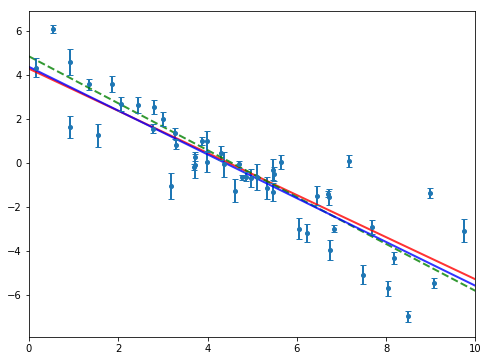

In [21]:
# plot all the data togther
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="g", linestyle='dashed', lw=2, alpha=0.8)
plt.plot(xl, m_ml*xl+b_ml, color="b", lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.show()

In [25]:
# write down priors if you’re going to use MCMC. the log-prior
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [26]:
# combine above with lnlike function: the full log-probability function 
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [27]:
# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# set up the sampler using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [28]:
# run the MCMC for 500 steps
foo = sampler.run_mcmc(pos, 500)

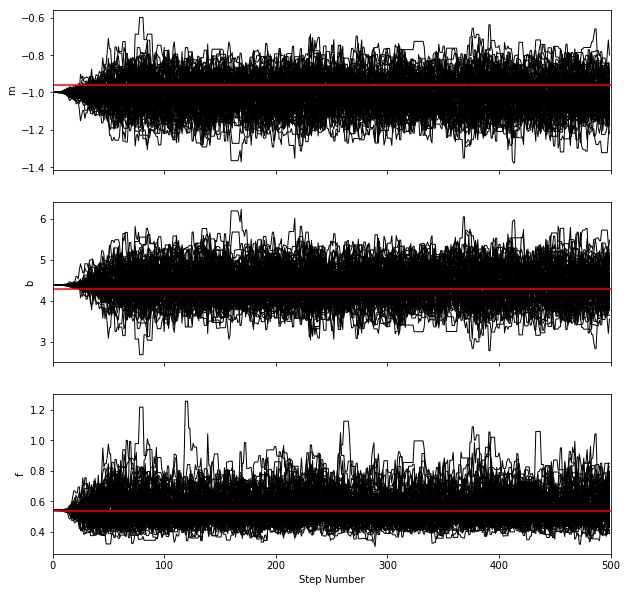

In [29]:
# plot positions of each walker as a function of the number of steps in the chain
x_axis = list(range(500))
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10,10))

for i in range(100):
    m_walk = []
    b_walk = []
    f_walk = []
    for j in range(500):
        m_walk.append(sampler.chain[i][j][0])
        b_walk.append(sampler.chain[i][j][1])
        f_walk.append(np.e**(sampler.chain[i][j][2]))
    ax1.plot(x_axis, m_walk, color='k', linewidth=1)
    ax2.plot(x_axis, b_walk, color='k', linewidth=1)
    ax3.plot(x_axis, f_walk, color='k', linewidth=1)
plt.xlim(0,500)
plt.xlabel("Step Number")
ax1.set_ylabel("m")
ax1.axhline(y=-0.9594, color='r', linestyle='-')
ax2.set_ylabel("b")
ax2.axhline(y=4.294, color='r', linestyle='-')
ax3.set_ylabel("f")
ax3.axhline(y=0.534, color='r', linestyle='-')
plt.show()

In [33]:
sampler.chain.shape

(100, 500, 3)

In [34]:
# discard the initial 50 steps (burnt-in) and flatten the chain
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

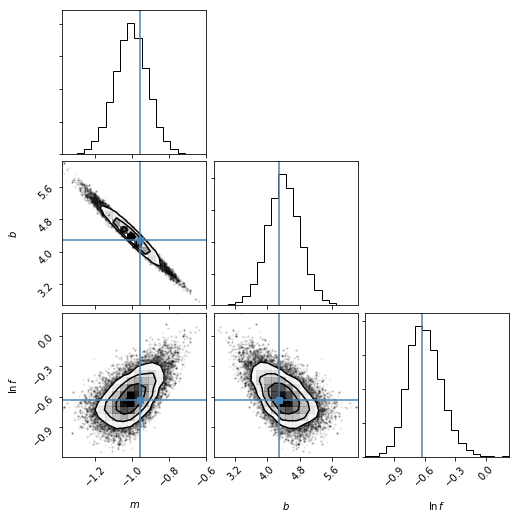

In [35]:
# based on MCMC results and generate a corner plot
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
plt.show()


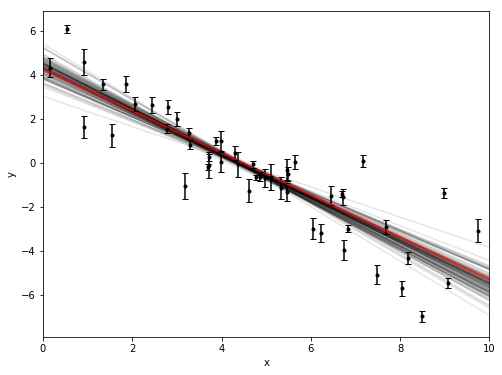

In [36]:
# choose a few (say 100 in this case) samples from the chain and plot them
fig = plt.figure(figsize=(8,6))
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=3)
plt.xlim(0,10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [37]:
# quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the 
# marginalized distributions
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [38]:
# print and compare results with true values
print(f"Final results: m={m_mcmc[0]:.4f}, b={b_mcmc[0]:.4f} and f={f_mcmc[0]:.4f}")
print(f"True values: m={m_true}, b={b_true} and f={f_true}")

Final results: m=-1.0057, b=4.4027 and f=0.5448
True values: m=-0.9594, b=4.294 and f=0.534
